In [44]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.colors import ListedColormap

import time

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True, linewidth=1000, precision=9)
np.random.seed(0)

In [2]:
train_dev = pd.read_csv("../data/train.csv", index_col=0)

In [3]:
# Save Y to an array
train_dev_Y = np.array(np.array(train_dev["Cover_Type"].tolist()))

# Binarize Y
def binarizeY(data):
    binarized_data = np.zeros((data.size,10))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data

train_dev_Y_bi = binarizeY(train_dev_Y)

In [4]:
# Pull out the features to normalize
X_norm_feat_list = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

train_dev_X_norm = np.array(train_dev[X_norm_feat_list])

print(train_dev_X_norm[0,:])

normer = preprocessing.StandardScaler()

train_dev_X_norm = normer.fit_transform(train_dev_X_norm)

print(train_dev_X_norm[0,:])

[2596   51    3  258    0  510  221  232  148 6279]
[-0.367095118 -0.959979824 -1.597131627  0.146639411 -0.834074226 -0.908681308  0.271453733  0.571653464  0.281258883  4.334805162]


In [5]:
# Pull out the wilderness area features
X_wild_feat_list = [
    'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'
]

train_dev_X_wild = np.array(train_dev[X_wild_feat_list])

In [6]:

# Pull out the soil area features
X_soil_feat_list = [
    'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
    'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
    'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
    'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
    'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
]

train_dev_X_soil = np.array(train_dev[X_soil_feat_list])

In [21]:
# Soil PCA section
n_comp = 1

X_soil_feat_list = ['pca_'+str(i+1) for i in range(n_comp)]
pca_mod = PCA(n_components = n_comp)
train_dev_X_soil = pca_mod.fit_transform(train_dev_X_soil)

In [22]:
# Choose features 
feature_list = X_norm_feat_list + X_wild_feat_list + X_soil_feat_list
print(feature_list)
# Stich together the normalized and binarized features
train_dev_X = np.concatenate((train_dev_X_norm, train_dev_X_wild, train_dev_X_soil), axis=1)
print(train_dev_X[0,:])

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'pca_1']
[-0.367095118 -0.959979824 -1.597131627  0.146639411 -0.834074226 -0.908681308  0.271453733  0.571653464  0.281258883  4.334805162  1.           0.           0.           0.          -0.264714311]


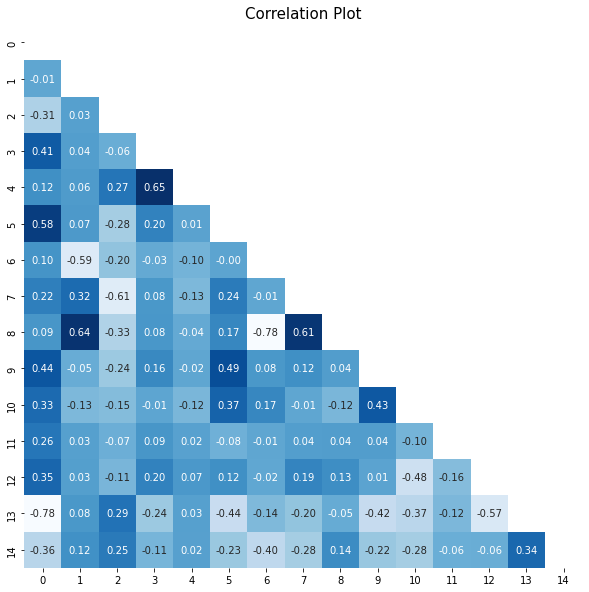

In [23]:
# correlation plot
corr = pd.DataFrame(train_dev_X).corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

In [24]:
## Split dev and train
n = train_dev_X.shape[0]
shuffle = np.random.permutation(np.arange(n))
X, Y = train_dev_X[shuffle], train_dev_Y[shuffle]

percent_in_dev = .2
dev_slice = int(percent_in_dev * n)

# Set some variables to dev and training data.
dev_dat, dev_lab = X[:dev_slice], Y[:dev_slice]
train_dat, train_lab = X[dev_slice:], Y[dev_slice:]

n_dev = dev_dat.shape[0]
n_train = train_dat.shape[0]
n_feat = train_dat.shape[1]

KNN accuracy with no filtering: 0.7833994708994709 for k = 1


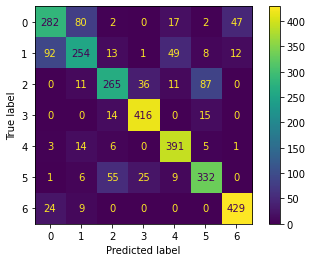

In [38]:
def knn(n_neighbors=1, train_dat=train_dat, train_lab=train_lab, dev_dat=dev_dat, dev_lab=dev_lab):
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    knn.fit(train_dat, train_lab) #train on processed train data

    pred_knn  = knn.predict(dev_dat) #predict on dev data

    accuracy_count_knn = 0

    for j in range(pred_knn.shape[0]):
        if pred_knn[j] == dev_lab[j]:
            accuracy_count_knn += 1
        else:
            continue

    print(f"KNN accuracy with no filtering: {accuracy_count_knn/pred_knn.shape[0]} for k = {n_neighbors}")

    cm = confusion_matrix(dev_lab, pred_knn)

    ConfusionMatrixDisplay(cm).plot()

    pd.DataFrame(classification_report(dev_lab, pred_knn, output_dict=True))

knn(n_neighbors=1)

GaussianNB accuracy w/ var smoothing @ .1: 0.5896164021164021


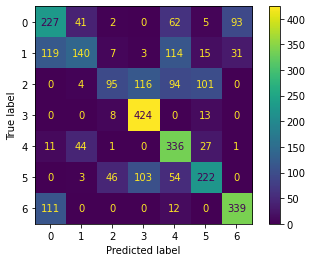

In [27]:
def gaussian_nb(train_dat=train_dat, train_lab=train_lab, dev_dat=dev_dat, dev_lab=dev_lab):

    ###Train on gaussianNB with var_smoothing = .1###

    model_gnb_s = GaussianNB(var_smoothing=.1)
    model_gnb_s.fit(train_dat,train_lab)

    sigmas2 = model_gnb_s.sigma_
    thetas2 = model_gnb_s.theta_

    ## predict on dev data

    pred_gnb_s = model_gnb_s.predict(dev_dat)
    accuracy_count_gnb_s = 0


    ###generate accuracy
    for j in range(dev_lab.shape[0]):
        if pred_gnb_s[j] == dev_lab[j]:
            accuracy_count_gnb_s += 1
        else:
            continue

    print("GaussianNB accuracy w/ var smoothing @ .1: " + str(accuracy_count_gnb_s/pred_gnb_s.shape[0]))

    cm = confusion_matrix(dev_lab, pred_gnb_s)

    ConfusionMatrixDisplay(cm).plot()

    pd.DataFrame(classification_report(dev_lab, pred_gnb_s, output_dict=True))


    
gaussian_nb()

Train time = 25.044591903686523
Predict time = 0.8457725048065186
Random Forest accuracy: 0.859457671957672


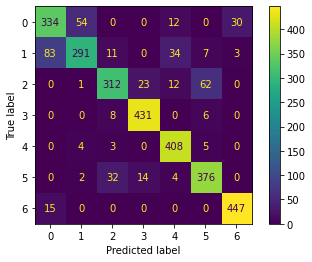

In [53]:
def randomforest(train_dat=train_dat, train_lab=train_lab, dev_dat=dev_dat, dev_lab=dev_lab):

    rf = RandomForestClassifier(
        n_estimators = 1000,
        criterion="entropy",
        max_depth=15,
        random_state = 42)

    start_time = time.time()
    rf.fit(train_dat, train_lab)
    print(f'Train time = {time.time() - start_time}')

    start_time = time.time()
    rf_pred = rf.predict(dev_dat).astype(int)
    print(f'Predict time = {time.time() - start_time}')

    ###generate accuracy
    accuracy_count_rf = 0
    for j in range(dev_lab.shape[0]):
        if rf_pred[j] == dev_lab[j]:
            accuracy_count_rf += 1
        else:
            continue

    print("Random Forest accuracy: " + str(accuracy_count_rf/rf_pred.shape[0]))

    cm = confusion_matrix(dev_lab, rf_pred)

    ConfusionMatrixDisplay(cm).plot()

    pd.DataFrame(classification_report(dev_lab, rf_pred, output_dict=True))

randomforest()